In [1]:
#pip install wandb --upgrade

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.15
    Uninstalling wandb-0.12.15:
      Successfully uninstalled wandb-0.12.15
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline

import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
import math

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet121
from itertools import cycle
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm

import wandb
from wandb.keras import WandbCallback

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kyulee (prophecy_ami). Use `wandb login --relogin` to force relogin


True

## Setting

In [2]:
#from PIL import Image
from tf_keras_vis.utils import num_of_gpus

# !pip install keras-vis
# !pip install tf-keras-vis

%reload_ext autoreload
%autoreload 2
%matplotlib inline

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


In [3]:
#from tf_keras_vis.utils import num_of_gpus
import collections
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
#from sklearn.model_selection import train_test_split
import matplotlib as mpl
#import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv1D,Conv2D, Flatten
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Check path
my_path = os.getcwd()
my_dir = '/home/ubuntu/Kyulee/ECG_2210/'
My_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/2023_Jan_testset/'
print('work_path: {}\ndata_directory: {}'.format(my_path, my_dir))

work_path: /home/ubuntu/Kyulee/ECG_2301
data_directory: /home/ubuntu/Kyulee/ECG_2210/


# 1. Data Load

In [6]:
# load dataset
X_test, Y_test = np.load(My_dir+'x_test_0114.npy'), np.load(My_dir+'y_test_0114.npy')

print('X_test {}, Y_test {}'.format(X_test.shape, Y_test.shape))

X_test (1318, 5000, 8), Y_test (1318,)


In [7]:
# Check dataset proportion
counter_test = collections.Counter(Y_test)

def proportion(counters):
    for i, counter in enumerate(counters):
        name = ['Test'][i]
        neg, pos = counter[0], counter[1]
        total = neg + pos
        print('{} Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
            name, total, pos, 100 * pos / total, neg, 100 * neg / total))
proportion([counter_test])

Test Examples:
    Total: 1318
    Positive: 129 (9.79% of total)
    Negative: 1189 (90.21% of total)



In [8]:
# Transform dataset to categorical (one-hot encoding)
y_test = tf.keras.utils.to_categorical(Y_test)
print('y_test {}'.format(y_test.shape))

y_test (1318, 2)


# 3. Modeling

In [8]:
# Load saved model
sing_model = keras.models.load_model(my_dir+'ami_model/0_model-best.h5')

In [9]:
# Load saved model
nets = 5
de_model = [0]*5
for i in [0,1,2,3,4]:
    de_model[i] = keras.models.load_model(my_dir+'ami_model/BestModelSaved/221204_1643'+str(i+1)+'_bestmodel.h5')

# 4. Test

In [14]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score

In [15]:
# confusion matrix
def matrix(y_true, y_pred, y_proba):
    conf_mat = confusion_matrix(y_true[:,1], y_pred[:,1])
    TP = conf_mat[1][1]
    TN = conf_mat[0][0]
    FN = conf_mat[1][0]
    FP = conf_mat[0][1]

    acc = round((TP+TN)/(TP+TN+FP+FN), 4)
    sens = round(TP/(TP+FN), 4)
    spec = round(TN/(TN+FP), 4)
    auroc = round(roc_auc_score(y_true, y_proba), 4)
    precision = round(precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    recall = round(recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    f1score = round(f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)

    print(conf_mat, "\n")
    print("Accuracy", acc)
    print("Sensitivity", sens)
    print("Specificity", spec)
    print("AUROC", auroc)
    print('Precision', precision)
    print("Recall", recall)
    print("F1",  f1score)
    print(classification_report(y_true, y_pred))
    
    # ROC & AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red'])
    for i, color in zip(range(y_true.shape[1]), colors):
        if i == 0:
            pass
        else:
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve (area = {0:0.2f})' ''.format(roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted', label = 'baseline')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

label = {'0': 'Not-STEMI', '1':'STEMI'}

In [16]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

def prc(y_true, y_pred, y_proba):
    # PR & AUC
    prec = dict()
    rec = dict()
    pr_auc = dict()
    for i in range(y_true.shape[1]):
        prec[i], rec[i], _ = sklearn.metrics.precision_recall_curve(y_true[:,i], y_proba[:, i])
        pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec[i], recall=rec[i])
    pr_display.plot(label = 'Precision-Recall curve (area = {0:0.2f})' ''.format(average_precision_score(y_true, y_pred)))
    plt.show()

label = {'0': 'Non-STEMI', '1':'STEMI'}

In [17]:
def plot_cm(labels, predictions, p):
    cf_matrix = confusion_matrix(labels, predictions > p)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages_pos = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[0:2]/np.sum(cf_matrix.flatten()[0:2])]
    group_percentages_neg = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[2:4]/np.sum(cf_matrix.flatten()[2:4])]
    group_percentages = group_percentages_pos + group_percentages_neg
    categories = ['Not-STEMI', 'STEMI']
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories, annot_kws={"size": 12})
    plt.title('Confusion Matrix (cut off = {:.2f})'.format(p), fontsize= 14)
    plt.ylabel('Actual label', fontsize= 12)
    plt.xlabel('Predicted label', fontsize= 12)

    print('True Negatives: ', cf_matrix[0][0])
    print('False Positives: ', cf_matrix[0][1])
    print('False Negatives: ', cf_matrix[1][0])
    print('True Positives: ', cf_matrix[1][1])
    print('Total STEMI: ', np.sum(cf_matrix[1]))

## 4.1. Single Model

In [10]:
# internal test
sing_proba = sing_model.predict(X_test)
sing_pred = (sing_proba > 0.5).astype(np.int64)

In [16]:
loss = sing_model.evaluate(X_test, y_test)
print(loss)

42/42 [==============================] - 1s 11ms/step - loss: 0.1020 - accuracy: 0.9644 - prc: 0.9835
[0.10199300944805145, 0.9643669724464417, 0.9834597110748291]


[[1163   25]
 [  22  109]] 

Accuracy 0.9644
Sensitivity 0.8321
Specificity 0.979
AUROC 0.9811
Precision 0.8134
Recall 0.8321
F1 0.8226
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1188
           1       0.81      0.83      0.82       131

   micro avg       0.96      0.96      0.96      1319
   macro avg       0.90      0.91      0.90      1319
weighted avg       0.96      0.96      0.96      1319
 samples avg       0.96      0.96      0.96      1319



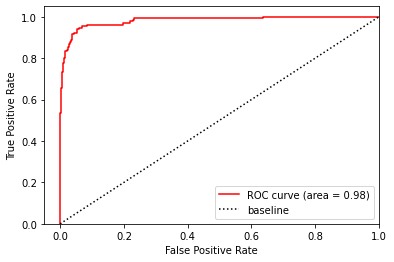

In [17]:
matrix(y_test, sing_pred, sing_proba)

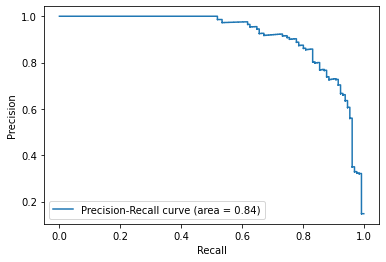

In [18]:
prc(y_test, sing_pred, sing_proba)

True Negatives:  1163
False Positives:  25
False Negatives:  22
True Positives:  109
Total STEMI:  131


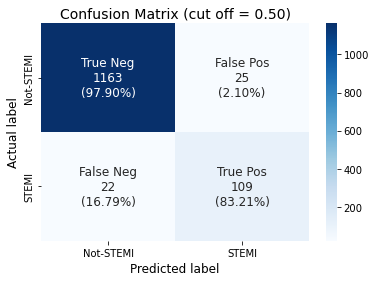

In [19]:
plot_cm(y_test[:,1], sing_pred[:,1])

In [20]:
import sklearn
from sklearn.calibration import calibration_curve

In [21]:
def calibration_plot(true, probs, n_bins):
    # reliability diagram
    prob_true, prob_pred = calibration_curve(true[:,1], probs[:,1], n_bins=n_bins)

    # plot perfectly calibrated
    plt.plot([0,1], [0,1], linestyle='--')

    # plot model reliability
    plt.plot(prob_pred, prob_true, marker='.')
    plt.title('Calibration Plot (bins: {0:d})' ''.format(n_bins))
    plt.show()

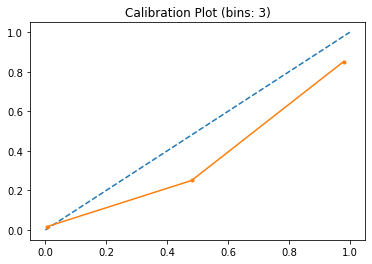

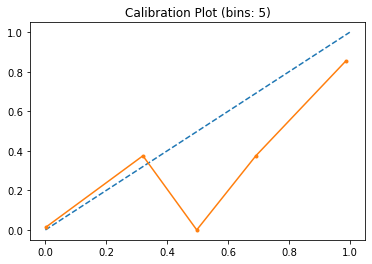

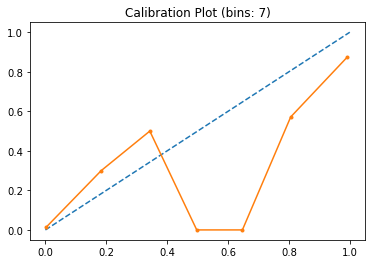

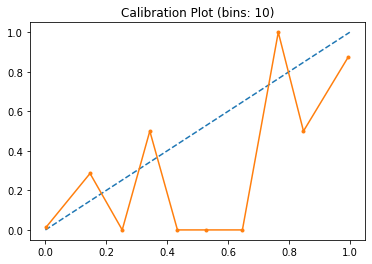

In [22]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, sing_proba, i)

## 4.2. Deep Ensemble

In [29]:
for m in de_model:
    loss = m.evaluate(X_test, y_test)
    print(loss)

42/42 [==============================] - 1s 12ms/step - loss: 0.1237 - accuracy: 0.9651 - prc: 0.9890
[0.12365199625492096, 0.9651250839233398, 0.9889984726905823]
42/42 [==============================] - 1s 10ms/step - loss: 0.0983 - accuracy: 0.9704 - prc: 0.9914
[0.09825931489467621, 0.9704321622848511, 0.9914310574531555]
42/42 [==============================] - 1s 10ms/step - loss: 0.1064 - accuracy: 0.9651 - prc: 0.9884
[0.10635349154472351, 0.9651250839233398, 0.9884479641914368]
42/42 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.9651 - prc: 0.9938
[0.09322711080312729, 0.9651250839233398, 0.9937710165977478]
42/42 [==============================] - 1s 10ms/step - loss: 0.1172 - accuracy: 0.9621 - prc: 0.9855
[0.11724250763654709, 0.9620925188064575, 0.9855208396911621]


In [82]:
(0.9809 + 0.9914 + 0.9884 + 0.9938 + 0.9855 )/5

0.9880000000000001

In [11]:
# Single
de_sing_proba= []
for m in de_model:
    proba = m.predict(X_test)
    de_sing_proba.append(proba)

# Ensemble
results = np.zeros( (y_test.shape[0],2) )
for s in de_sing_proba:
    results = results + s

de_proba = results/5
de_pred = (de_proba > 0.5).astype(np.int64)

[[1168   20]
 [  19  112]] 

Accuracy 0.9704
Sensitivity 0.855
Specificity 0.9832
AUROC 0.9816
Precision 0.8485
Recall 0.855
F1 0.8517
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1188
           1       0.85      0.85      0.85       131

   micro avg       0.97      0.97      0.97      1319
   macro avg       0.92      0.92      0.92      1319
weighted avg       0.97      0.97      0.97      1319
 samples avg       0.97      0.97      0.97      1319



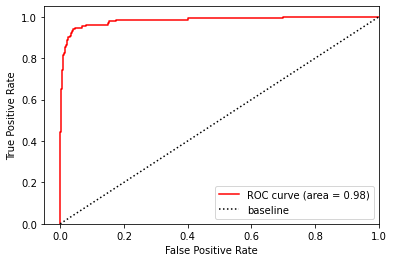

In [31]:
# Esemble Result (test) -- result after loading
matrix(y_test, de_pred, de_proba)

In [32]:
round(average_precision_score(y_test, de_pred), 2)

0.86

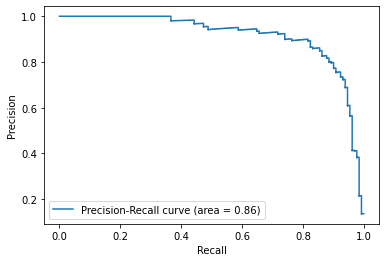

In [33]:
prc(y_test, de_pred, de_proba)

True Negatives:  1168
False Positives:  20
False Negatives:  19
True Positives:  112
Total STEMI:  131


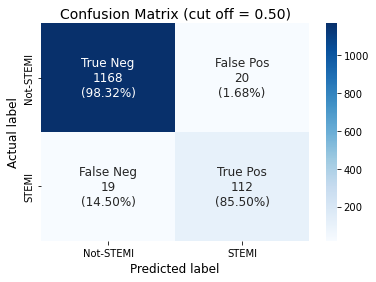

In [34]:
plot_cm(y_test[:,1],de_pred[:,1])

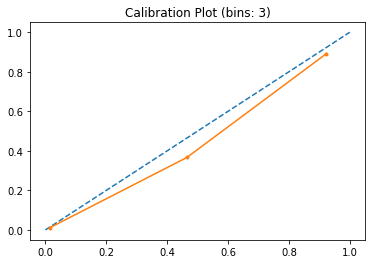

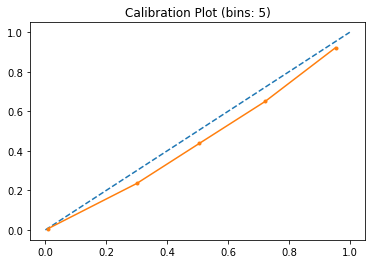

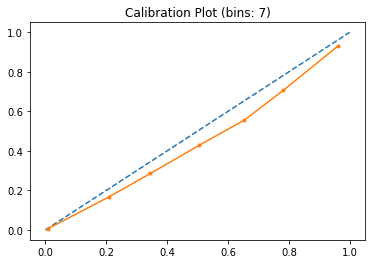

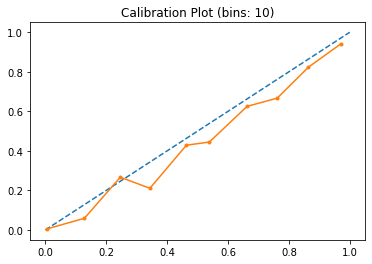

In [35]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, de_proba, i)

# 5. F1-Score
- https://gist.github.com/twolodzko/4fae2980a1f15f8682d243808e5859bb

In [119]:
from sklearn.metrics import roc_curve
def f1max(y_true, y_proba):
    pre, rec, thresholds = sklearn.metrics.precision_recall_curve(y_true[:,1], y_proba[:, 1])
    f1s = (2 * rec * pre) / (rec+pre)
    idx = np.argmax(f1s)
    return thresholds[idx]

In [156]:
# f1'score max index
sing_fi = round(f1max(y_test, sing_proba),4)
de_fi = round(f1max(y_test, de_proba),4)

print(' single model: {}\n deep ensemble: {}'.format(sing_fi, de_fi))
#print(' single model: {}'.format(sing_yi))

 single model: 0.7509999871253967
 deep ensemble: 0.5176


### 5.1. Single Model

In [157]:
# internal test
sing_pred_fi = (sing_proba > sing_fi).astype(np.int64)

[[1170   18]
 [  22  109]] 

Accuracy 0.9697
Sensitivity 0.8321
Specificity 0.9848
AUROC 0.9811
Precision 0.8583
Recall 0.8321
F1 0.845
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1188
           1       0.86      0.83      0.84       131

   micro avg       0.97      0.96      0.97      1319
   macro avg       0.92      0.90      0.91      1319
weighted avg       0.97      0.96      0.97      1319
 samples avg       0.96      0.96      0.96      1319



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


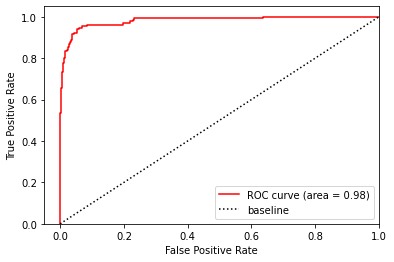

In [158]:
matrix(y_test, sing_pred_fi, sing_proba)

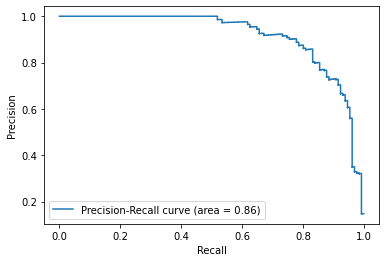

In [140]:
prc(y_test, sing_pred_fi, sing_proba)

True Negatives:  1170
False Positives:  18
False Negatives:  22
True Positives:  109
Total STEMI:  131


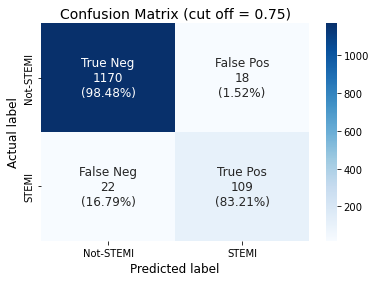

In [171]:
plot_cm(y_test[:,1], sing_pred_fi[:,1], sing_fi)

### 5.2. Deep Ensemble

In [159]:
def prob_demodel(de_model, x_dataset, cut_off):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    #de_pred = (de_proba > cut_off).astype(np.int64)
    return de_proba

def pred_demodel(de_model, x_dataset, cut_off):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    de_pred = (de_proba > cut_off).astype(np.int64)
    return de_pred

#de_proba_fi = prob_demodel(de_model, X_test, de_fi)
de_pred_fi = pred_demodel(de_model, X_test, de_fi)

[[1170   18]
 [  20  111]] 

Accuracy 0.9712
Sensitivity 0.8473
Specificity 0.9848
AUROC 0.9816
Precision 0.8605
Recall 0.8473
F1 0.8538
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1188
           1       0.86      0.85      0.85       131

   micro avg       0.97      0.97      0.97      1319
   macro avg       0.92      0.91      0.92      1319
weighted avg       0.97      0.97      0.97      1319
 samples avg       0.97      0.97      0.97      1319



/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


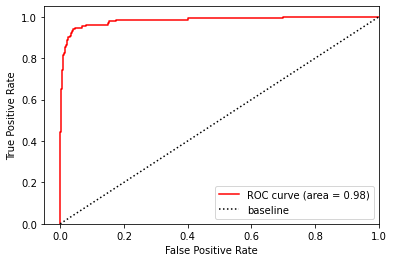

In [160]:
# Esemble Result (test) -- result after loading
matrix(y_test, de_pred_fi, de_proba)

In [127]:
round(average_precision_score(y_test, de_pred_fi), 2)

0.86

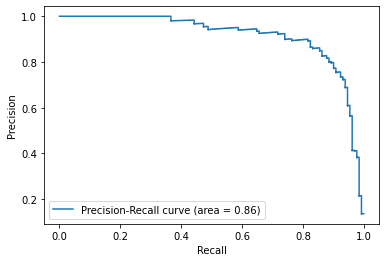

In [161]:
prc(y_test, de_pred_fi, de_proba)

True Negatives:  1170
False Positives:  18
False Negatives:  20
True Positives:  111
Total STEMI:  131


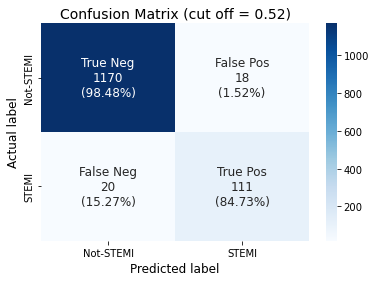

In [172]:
plot_cm(y_test[:,1],de_pred_fi[:,1], de_fi)

# 6. Youden's index
- https://gist.github.com/twolodzko/4fae2980a1f15f8682d243808e5859bb

In [18]:
from sklearn.metrics import roc_curve
def youden(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true[:,1], y_proba[:, 1])
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [22]:
# f1'score max index
sing_yi = round(youden(y_test, sing_proba),4)
de_yi = round(youden(y_test, de_proba),4)

print(' single model: {}\n deep ensemble: {}'.format(sing_yi, de_yi))
#print(' single model: {}'.format(sing_yi))

 single model: 0.01899999938905239
 deep ensemble: 0.1524


### 5.1. Single Model

In [23]:
# internal test
sing_pred_yi = (sing_proba > sing_yi).astype(np.int64)

[[1117   71]
 [   8  123]] 

Accuracy 0.9401
Sensitivity 0.9389
Specificity 0.9402
AUROC 0.9811
Precision 0.9159
Recall 0.7481
F1 0.8235
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1188
           1       0.63      0.94      0.76       131

   micro avg       0.93      0.99      0.96      1319
   macro avg       0.80      0.97      0.87      1319
weighted avg       0.94      0.99      0.96      1319
 samples avg       0.95      0.99      0.97      1319



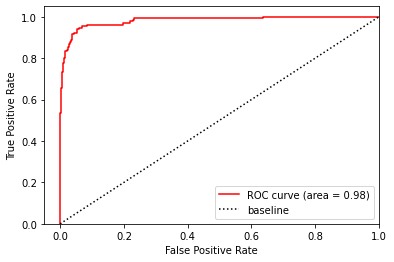

In [24]:
matrix(y_test, sing_pred_yi, sing_proba)

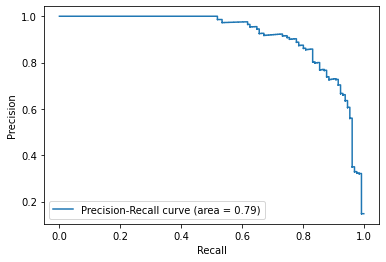

In [25]:
prc(y_test, sing_pred_yi, sing_proba)

True Negatives:  1117
False Positives:  71
False Negatives:  8
True Positives:  123
Total STEMI:  131


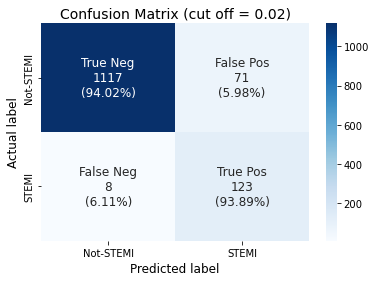

In [26]:
plot_cm(y_test[:,1], sing_pred_yi[:,1], sing_yi)

### 5.2. Deep Ensemble

In [27]:
def prob_demodel(de_model, x_dataset, cut_off):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    #de_pred = (de_proba > cut_off).astype(np.int64)
    return de_proba

def pred_demodel(de_model, x_dataset, cut_off):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    de_pred = (de_proba > cut_off).astype(np.int64)
    return de_pred

de_proba_yi = prob_demodel(de_model, X_test, de_yi)
de_pred_yi = pred_demodel(de_model, X_test, de_yi)

[[1132   56]
 [   7  124]] 

Accuracy 0.9522
Sensitivity 0.9466
Specificity 0.9529
AUROC 0.9816
Precision 0.9286
Recall 0.6947
F1 0.7948
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1188
           1       0.69      0.95      0.80       131

   micro avg       0.93      0.99      0.96      1319
   macro avg       0.83      0.97      0.89      1319
weighted avg       0.94      0.99      0.96      1319
 samples avg       0.96      0.99      0.97      1319



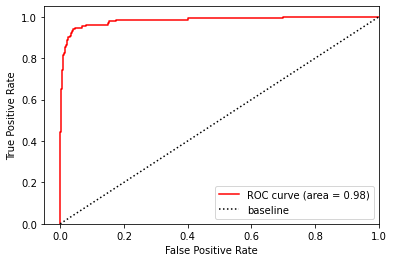

In [28]:
# Esemble Result (test) -- result after loading
matrix(y_test, de_pred_yi, de_proba_yi)

In [127]:
round(average_precision_score(y_test, de_pred_yi), 2)

0.86

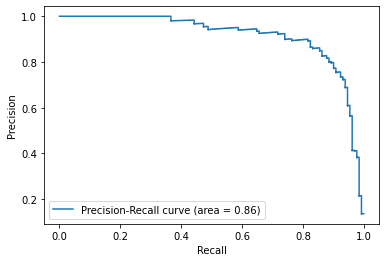

In [128]:
prc(y_test, de_pred_yi, de_proba_yi)

True Negatives:  1132
False Positives:  56
False Negatives:  7
True Positives:  124
Total STEMI:  131


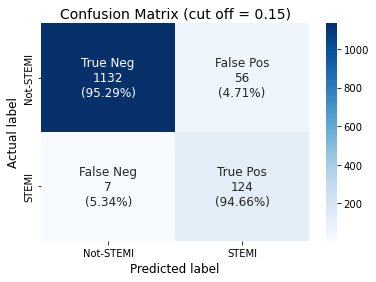

In [29]:
plot_cm(y_test[:,1],de_pred_yi[:,1], de_yi)

# 6. Uncertainty (Entropy) Estimation

## 6.1. cut-off= 0.5

In [12]:
# Deep Ensembles
de_entropy_list = []
for i in range(len(de_proba)):
    pq = de_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    de_entropy_list.append(entropy)

In [13]:
# Single 
sing_entropy_list = []
for i in range(len(sing_proba)):
    pq = sing_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    sing_entropy_list.append(entropy)

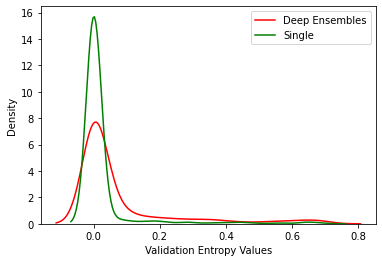

In [14]:
# plot distribution
sns.kdeplot(de_entropy_list, label='Deep Ensembles', color='r')
sns.kdeplot(sing_entropy_list, label='Single', color='g')
plt.xlabel('Validation Entropy Values')
plt.legend()
plt.show()

## 5.3. Divide Groups and Check Each Group's Results
Uncertainty cutoff 0.0018 (internal test - deep ensemble's entropy의 median)

##### median, mean, quantile

In [45]:
import statistics

In [46]:
med_ls = []
for i, ls in enumerate([de_entropy_list, sing_entropy_list]):
    med = round(statistics.median(ls),5)
    med_ls.append(med)
print('median\nde_entropy {}, sing_entropy {}'.format(med_ls[0], med_ls[1]))

median
de_entropy 0.00201, sing_entropy 0.0


In [47]:
quant_ls = []
for i, ls in enumerate([de_entropy_list, sing_entropy_list]):
    quant = round(statistics.quantiles(ls)[2],2)
    quant_ls.append(quant)
print('quantiles\nde_entropy {}, sing_entropy {}'.format(quant_ls[0], quant_ls[1]))

quantiles
de_entropy 0.05, sing_entropy 0.0


In [48]:
mean_ls = []
for i, ls in enumerate([de_entropy_list, sing_entropy_list]):
    mean = round(statistics.mean(ls),5)
    mean_ls.append(med)
print('mean\nde_entropy {}, sing_entropy {}'.format(mean_ls[0], mean_ls[1]))

mean
de_entropy 0.0, sing_entropy 0.0


In [49]:
print('X_test {}, Y_test {}'.format(X_test.shape, Y_test.shape))

X_test (1319, 5000, 8), Y_test (1319,)


##### 5%, 10%, 15%, 20%

In [59]:
def uc_grouping(entropy_list, cutoff):
    high_idx = []
    low_idx = []
    for idx, entropy in enumerate(entropy_list):
        if entropy >= cutoff:
            high_idx.append(idx)
        else:
            low_idx.append(idx)
            
    return high_idx, low_idx

In [289]:
print('high 5%: {}'.format(round(len(y_test)*0.05),2))
print('high 10%: {}'.format(round(len(y_test)*0.1),2))
print('high 15%: {}'.format(round(len(y_test)*0.15),2))
print('high 20%: {}'.format(round(len(y_test)*0.2),2))

high 5%: 66
high 10%: 132
high 15%: 198
high 20%: 264


In [305]:
def get_co(list_a, percent):
    '''
    list_a: [int, int, ...] 
    num: int, 추출하고 싶은 개수 
    '''
    tmp = list_a.copy()
    tmp.sort()
    num = round(len(y_test)* percent*0.01)
    top_num = tmp[-num:]
    cutoff = round(min(top_num),4)
    
    return cutoff

### 5.3.1. Deep Ensembles

In [340]:
cut_off = get_co(de_entropy_list, 20)

In [341]:
de_high, de_low = uc_grouping(de_entropy_list, cutoff=cut_off)
print(len(de_high), len(de_low))

print("Uncertainty High: %.2f%%" % (len(de_high) / len(de_entropy_list) * 100.0))
print("Uncertainty Low: %.2f%%" % (len(de_low) / len(de_entropy_list) * 100.0))
print("cut-off: {}".format(cut_off))

263 1056
Uncertainty High: 19.94%
Uncertainty Low: 80.06%
cut-off: 0.0959


In [342]:
# Matrix 위해 ensemble 결과 필요
de_test_high = y_test[de_high]
de_pred_high = de_pred[de_high]
de_proba_high = de_proba[de_high]

de_test_low = y_test[de_low]
de_pred_low = de_pred[de_low]
de_proba_low = de_proba[de_low]

[[161  20]
 [ 15  67]] 

Accuracy 0.8669
Sensitivity 0.8171
Specificity 0.8895
AUROC 0.921
Precision 0.7701
Recall 0.8171
F1 0.7929
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       181
           1       0.77      0.82      0.79        82

   micro avg       0.87      0.87      0.87       263
   macro avg       0.84      0.85      0.85       263
weighted avg       0.87      0.87      0.87       263
 samples avg       0.87      0.87      0.87       263



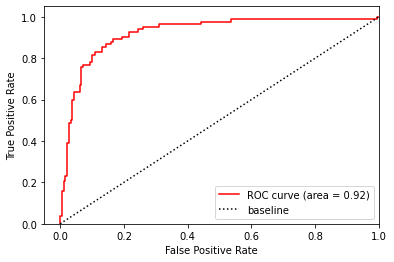

[[1007    0]
 [   4   45]] 

Accuracy 0.9962
Sensitivity 0.9184
Specificity 1.0
AUROC 0.9803
Precision 1.0
Recall 0.9184
F1 0.9574
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1007
           1       1.00      0.92      0.96        49

   micro avg       1.00      1.00      1.00      1056
   macro avg       1.00      0.96      0.98      1056
weighted avg       1.00      1.00      1.00      1056
 samples avg       1.00      1.00      1.00      1056



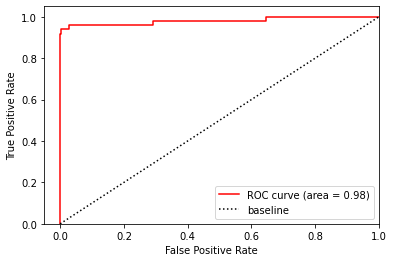

In [343]:
matrix(de_test_high, de_pred_high, de_proba_high)
matrix(de_test_low, de_pred_low, de_proba_low)

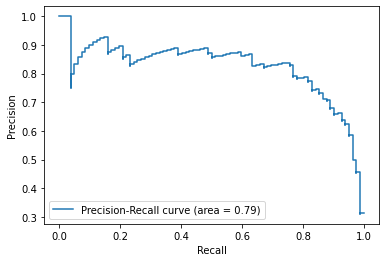

In [346]:
prc(de_test_high, de_pred_high, de_proba_high)

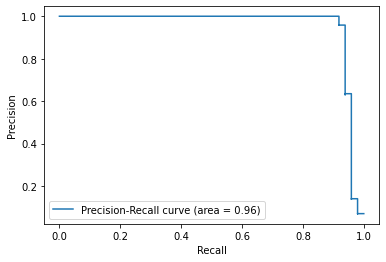

In [347]:
prc(de_test_low, de_pred_low, de_proba_low)

True Negatives:  161
False Positives:  20
False Negatives:  15
True Positives:  67
Total STEMI:  82


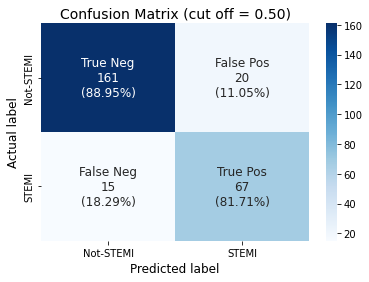

In [348]:
plot_cm(de_test_high[:,1], de_pred_high[:,1], 0.5)

True Negatives:  1007
False Positives:  0
False Negatives:  4
True Positives:  45
Total STEMI:  49


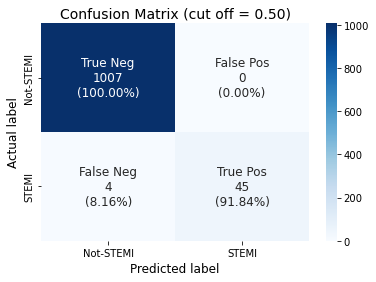

In [349]:
plot_cm(de_test_low[:,1], de_pred_low[:,1], 0.5)

#### 5.3.1.2. Single Net

In [350]:
cut_off = get_co(sing_entropy_list, 20)

sing_high, sing_low = uc_grouping(sing_entropy_list, cutoff=cut_off)
print(len(sing_high), len(sing_low))

print("Uncertainty High: %.2f%%" % (len(sing_high) / len(sing_entropy_list) * 100.0))
print("Uncertainty Low: %.2f%%" % (len(sing_low) / len(sing_entropy_list) * 100.0))
print("cut-off: {}".format(cut_off))

266 1053
Uncertainty High: 20.17%
Uncertainty Low: 79.83%
cut-off: 0.0008


In [351]:
# Matrix 위해 ensemble 결과 필요
sing_test_high = y_test[sing_high]
sing_pred_high = sing_pred[sing_high]
sing_proba_high = sing_proba[sing_high]

sing_test_low = y_test[sing_low]
sing_pred_low = sing_pred[sing_low]
sing_proba_low = sing_proba[sing_low]

[[154  25]
 [ 17  70]] 

Accuracy 0.8421
Sensitivity 0.8046
Specificity 0.8603
AUROC 0.9276
Precision 0.7368
Recall 0.8046
F1 0.7692
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       179
           1       0.74      0.80      0.77        87

   micro avg       0.84      0.84      0.84       266
   macro avg       0.82      0.83      0.82       266
weighted avg       0.85      0.84      0.84       266
 samples avg       0.84      0.84      0.84       266



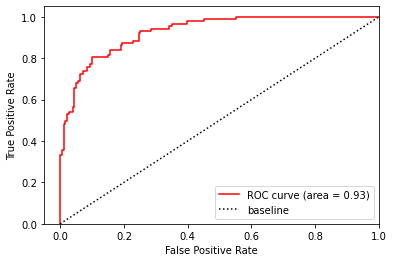

[[1009    0]
 [   5   39]] 

Accuracy 0.9953
Sensitivity 0.8864
Specificity 1.0
AUROC 0.9793
Precision 1.0
Recall 0.8864
F1 0.9398
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      0.89      0.94        44

   micro avg       1.00      1.00      1.00      1053
   macro avg       1.00      0.94      0.97      1053
weighted avg       1.00      1.00      1.00      1053
 samples avg       1.00      1.00      1.00      1053



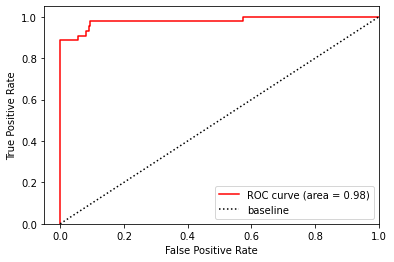

In [352]:
#cutoff 0.25
matrix(sing_test_high, sing_pred_high, sing_proba_high)
matrix(sing_test_low, sing_pred_low, sing_proba_low)

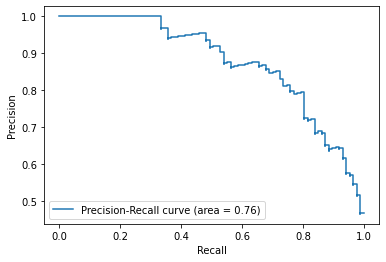

In [353]:
prc(sing_test_high, sing_pred_high, sing_proba_high)

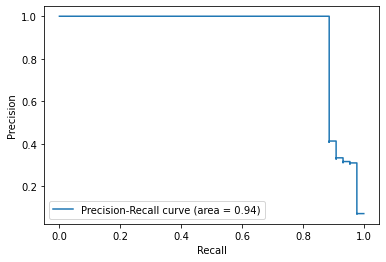

In [354]:
prc(sing_test_low, sing_pred_low, sing_proba_low)

True Negatives:  154
False Positives:  25
False Negatives:  17
True Positives:  70
Total STEMI:  87


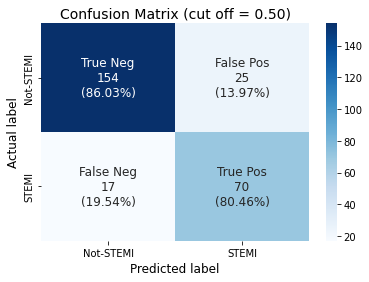

In [355]:
plot_cm(sing_test_high[:,1], sing_pred_high[:,1],0.5)

True Negatives:  1009
False Positives:  0
False Negatives:  5
True Positives:  39
Total STEMI:  44


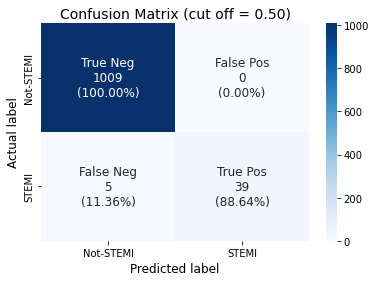

In [356]:
plot_cm(sing_test_low[:,1], sing_pred_low[:,1],0.5)